In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pystan
import pybaseball
import arviz as az

In [2]:
player_names = ["Peter Alonso","Keston Hiura","Fernando Tatis Jr.","Harold Ramirez","Jose Trevino","Yordan Alvarez","Vladimir Guerrero Jr.","Steve Wilkerson"]

In [3]:
batter_data = pybaseball.batting_stats(2019)

In [4]:
batter_data = batter_data.loc[batter_data['Name'].isin(player_names)].set_index("Name")
batter_data

,Season,Team,Age,G,AB,PA,H,1B,2B,3B,...,wSL/C (pi),wXX/C (pi),O-Swing% (pi),Z-Swing% (pi),Swing% (pi),O-Contact% (pi),Z-Contact% (pi),Contact% (pi),Zone% (pi),Pace (pi)
Name,,,,,,,,,,,,,,,,,,,,,
Peter Alonso,2019.0,Mets,24.0,161.0,597.0,693.0,155.0,70.0,30.0,2.0,...,0.25,NaN,0.339,0.652,0.468,0.599,0.825,0.729,0.414,25.1
Yordan Alvarez,2019.0,Astros,22.0,87.0,313.0,369.0,98.0,45.0,26.0,0.0,...,3.49,NaN,0.311,0.591,0.434,0.623,0.853,0.761,0.439,24.4
Fernando Tatis Jr.,2019.0,Padres,20.0,84.0,334.0,372.0,106.0,65.0,13.0,6.0,...,1.95,4.87,0.304,0.701,0.477,0.445,0.800,0.673,0.436,25.0
Keston Hiura,2019.0,Brewers,22.0,84.0,314.0,348.0,95.0,51.0,23.0,2.0,...,2.56,NaN,0.318,0.729,0.515,0.423,0.769,0.657,0.479,24.2
Vladimir Guerrero Jr.,2019.0,Blue Jays,20.0,123.0,464.0,514.0,126.0,83.0,26.0,2.0,...,-1.39,NaN,0.301,0.681,0.467,0.592,0.875,0.772,0.437,25.3
Harold Ramirez,2019.0,Marlins,24.0,119.0,421.0,446.0,116.0,82.0,20.0,3.0,...,-0.85,NaN,0.402,0.715,0.540,0.610,0.875,0.765,0.442,23.3
Jose Trevino,2019.0,Rangers,26.0,40.0,120.0,126.0,31.0,20.0,9.0,0.0,...,-2.29,NaN,0.413,0.554,0.486,0.716,0.848,0.794,0.520,23.4
Steve Wilkerson,2019.0,Orioles,27.0,119.0,329.0,361.0,74.0,44.0,18.0,2.0,...,-0.51,NaN,0.344,0.572,0.454,0.637,0.819,0.748,0.484,24.2


In [5]:
binomial_data = {}
for player in batter_data.index:
    hits = int(batter_data.loc[player]["H"])
    ab_minus_hits = int(batter_data.loc[player]["AB"]) - hits
    ab_outcomes = [0]*ab_minus_hits + [1]*hits
    binomial_data.update({player:ab_outcomes})
at_bat_totals = {}
for player in batter_data.index:
    at_bat_count = int(batter_data.loc[player]["AB"])
    at_bat_totals.update({player:at_bat_count})
hit_totals = {}
for player in batter_data.index:
    hit_count = int(batter_data.loc[player]["H"])
    hit_totals.update({player:hit_count})

$BA_i \sim Beta(81,219)$

$y_i \sim Bin(AB_i,BA_i)$

$i=1,2,...,8$

In [6]:
#https://mc-stan.org/users/documentation/case-studies/rstan_workflow.html
#https://people.duke.edu/~ccc14/sta-663/PyStan.html
#http://varianceexplained.org/statistics/beta_distribution_and_baseball/

model_code = '''
data {
  int<lower=0> N;
  int<lower=0> at_bats[N];
  int<lower=0> hits[N];
  real<lower=0> A;
  real<lower=0> B;
}
parameters {
  real<lower=0,upper=1> AVG[N];
}
model {
  AVG ~ beta(A, B);
  hits ~ binomial(at_bats, AVG);
}
generated quantities {
    vector[N] log_lik;
    vector[N] predicted_hits;
    for (i in 1:N) {
        log_lik[i] = binomial_lpmf(hits[i] | at_bats[i], AVG[i]);
        predicted_hits[i] = binomial_rng(at_bats[i], AVG[i]);
    }
}
'''

model_data = dict(N=8, hits=list(hit_totals.values()),at_bats=list(at_bat_totals.values()),A=81,B=219)
stan_model = pystan.StanModel(model_code=model_code)
fit = stan_model.sampling(data=model_data)


INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_4d40fdfa42b9a644c6433b2a714e9368 NOW.


In [7]:
print(fit)

Inference for Stan model: anon_model_4d40fdfa42b9a644c6433b2a714e9368.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                    mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
AVG[1]              0.26  1.7e-4   0.01   0.24   0.25   0.26   0.27   0.29   7260    1.0
AVG[2]              0.29  2.2e-4   0.02   0.26   0.28   0.29    0.3   0.33   6842    1.0
AVG[3]               0.3  2.2e-4   0.02   0.26   0.28   0.29   0.31   0.33   6528    1.0
AVG[4]              0.29  2.1e-4   0.02   0.25   0.27   0.29    0.3   0.32   7373    1.0
AVG[5]              0.27  2.1e-4   0.02   0.24   0.26   0.27   0.28    0.3   5894    1.0
AVG[6]              0.27  2.0e-4   0.02   0.24   0.26   0.27   0.28   0.31   6362    1.0
AVG[7]              0.27  2.7e-4   0.02   0.23   0.25   0.27   0.28   0.31   5854    1.0
AVG[8]              0.25  2.1e-4   0.02   0.22   0.24   0.25   0.26   0.28   6435    1.0
log_lik[1]

In [8]:
prior_model_code = '''
data {
  int<lower=0> N;
  real<lower=0> A;
  real<lower=0> B;
}

parameters {
  real<lower=0,upper=1> AVG[N];
}

model {
  AVG ~ beta(A, B);
  }
'''

prior_model_data = dict(N=8,A=81,B=219)
stan_model_prior = pystan.StanModel(model_code=prior_model_code)
prior_fit = stan_model_prior.sampling(data=prior_model_data)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_390c11193c42041ad1d6bfb9bf37ebfd NOW.


In [9]:
stan_data = az.from_pystan(posterior=fit,
                           prior=prior_fit,
                           observed_data="hits",
                           posterior_predictive="predicted_hits",
                           log_likelihood="log_lik",
                           posterior_model=stan_model,
                           coords={"player":list(hit_totals.keys())},
                           dims={'AVG': ['player'], 'hits': ['player'], 'log_lik': ['player'], 'predicted_hits': ['player']})

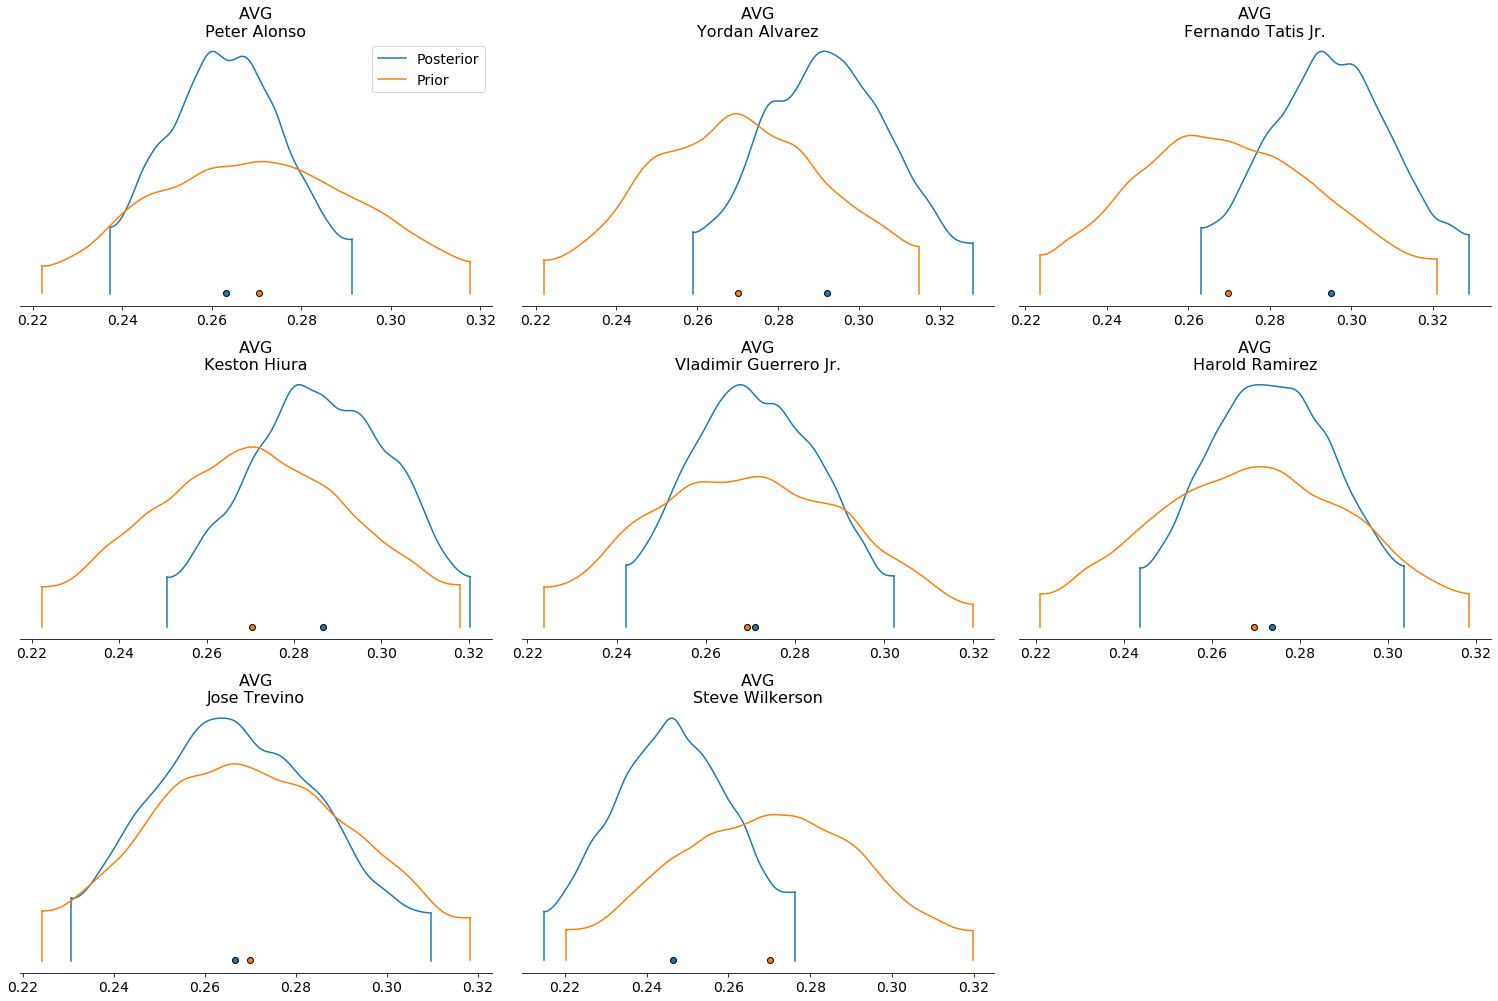

In [10]:
density_plots = az.plot_density([stan_data.posterior,stan_data.prior],data_labels=["Posterior","Prior"])

array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000025AE365B588>],
      dtype=object)

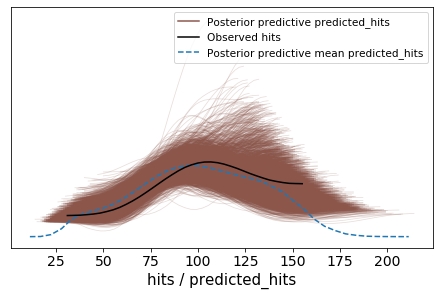

In [11]:
az.plot_ppc(stan_data, data_pairs = {"hits" : "predicted_hits"},flatten=["player"])